![](https://i.pinimg.com/564x/f9/ae/ef/f9aeef0f646f4711bfaf5d837f8766e2.jpg)

# Extended Kalman Filter

Kevin J. Walchko, Phd

21 June 2020

---

What is a Kalman Filter:

- A Kalman filter is an optimal estimator 
    - It infers parameters of interest from indirect, inaccurate and uncertain observations. 
    - It is recursive so that new measurements can be processed as they arrive.

Optimal in what sense:

- If Noise is Gaussian: the Kalman filter minimizes the mean square error of the estimated parameters.
- If Noise is NOT Gaussian: Kalman filter is still the best linear estimator. Nonlinear estimators may be better. 

Extended Kalman Filter (EKF)

- Designed to work on nonlinear systems
- Must be able to compute a Jacobian
- More computational than a normal Kalman filter
- EKF is not optimcal if the system is highly nonlinear

### Basic Operation

1. Initialize
1. Loop:
    1. Measure
    1. Update
    1. Predict

### Model

$$
\dot x(t) = f(x(t), u(t)) + w(t) \quad w(t) \sim \mathcal{N}(0,Q(t))\\
z(t) = h(x(t)) + v(t) \quad v(t) \sim \mathcal{N}(0,R(t))
$$

### Jacobians

$$
F(t)=\frac{\partial f}{\partial x} \Bigr|_{\hat x(t), u(t)} \\
H(t)=\frac{\partial h}{\partial x} \Bigr|_{\hat x(t)}
$$

### Initialize

$$
\hat x(t_0) = E[x(t_x)] \\
P(t_0) = Var[x(t_0)]
$$

### Predict-Update

$$
\dot{\hat x}(t) = f(\hat x(t), u(t)) + K(t)(z(t)-h(\hat x(t))) \\
\dot P(t)=F(t)P(t)+P(t)F(t)^T-K(t)H(t)P(t)+Q(t) \\
K(t)=P(t)H(t)^T R(t)^{-1}
$$

### Flow Diagram for Discrete EKF

A continuous-discrete EKF is very similar.

![](pics/ekf.png)

## Overview

| State Estimator | Model | Assumed Distribution | Computational Cost |
|-----------------|-------|----------------------|--------------------|
| Kalman Filter   | Linear         | Gaussian     | Low |
| Extended KF     | Locally Linear | Gaussian     | Medium |
| Unscented KF    | Nonlinear      | Gaussian     | Medium |
| Particle Filter | Nonlinear      | Non-Gaussian | High |


## Robot

![](pics/robot.png)

$$
\begin{align*}
v &= \frac{r}{2} \left( \dot \phi_R + \dot \phi_L \right) \\
\\
\dot x &= \cos(\theta) v \\
\dot y &= \sin(\theta) v \\
\dot \theta &= \frac{r}{2d} \left( \dot \phi_R - \dot \phi_L \right)
\end{align*}
$$

where $v$ is the linear speed of the robot, ($x$,$y$) is the position of the robot's center mass, $\theta$ is the heading, and $\dot \phi_{R|L}$ is the wheel speed for the right or left wheel. 

## References

- [Extended Kalman Filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter)
- [MathWorks Understanding Kalman Filters](https://www.mathworks.com/videos/series/understanding-kalman-filters.html)
- [Differential robot equations](https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html)
- [Discrete EKF Tutorial](tutorialEKF.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

from pyrk import RK4
from squaternion import Quaternion
from thundercougarfalconbird.models import DifferentialDriveKinematics
from thundercougarfalconbird.sensors import SensorNoise
from spiceweasel.ekf import EKF

In [27]:
deg2rad = np.pi/180
rad2deg = 180/np.pi

## Simulation

Create a simulation and add some noise to it.

In [28]:
savex = []
saveu = []

# create a robot
robot = DifferentialDriveKinematics(.02,.1)

x = np.zeros(3)
dt = 0.1
rk = RK4(robot.eqns, dt)
times = np.arange(0,40,dt)

for t in times:
    # made a simple changing control effort that makes
    # an interesting path
    u = [10*np.cos(t/25), 10*np.sin(t/25)]
    saveu.append(u)
    x = rk(t,x,u)
    savex.append(x)
    
# convert lists to numpy arrays
savex = np.array(savex)
saveu = np.array(saveu)

# Generate noise for position and heading
senpos = SensorNoise(0.001,0.01)
senhead = SensorNoise(0.0,0.1)

# add the noise to the true path
num = len(savex)
sen = np.hstack((senpos.noise(num,2), senhead.noise(num)))
savexn = savex + sen

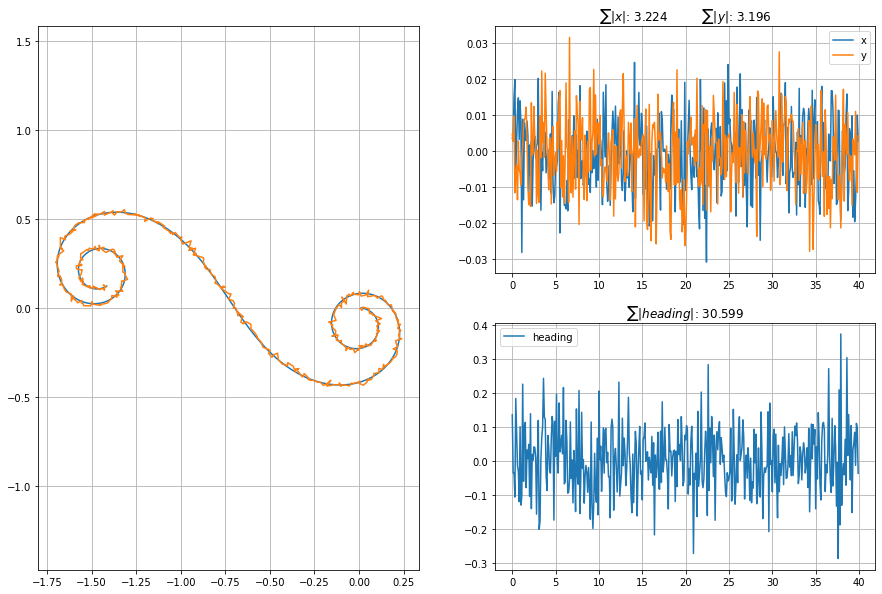

In [29]:
# plot a bunch of stuff
err = savex - savexn
ex = err[:,0]
ey = err[:,1]
eh = err[:,2]

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(savex[:,0], savex[:,1])
plt.plot(savexn[:,0], savexn[:,1])
plt.axis('equal')
plt.grid(True)

plt.subplot(222)
plt.title(f"$\sum |x|$: {np.sum(np.abs(ex)):.3f}         $\sum |y|$: {np.sum(np.abs(ey)):.3f}")
plt.plot(times,ex, label="x")
plt.plot(times,ey, label="y")
plt.legend()
plt.grid(True);

plt.subplot(224)
plt.title(f"$\sum |heading|$: {np.sum(np.abs(eh)):.3f}")
plt.plot(times, eh, label="heading")
plt.legend()
plt.grid(True);

## Extended Kalman Filtering

Now that we have a bunch of noisy data, let's filter out the noise and try to get a better understanding of the robot's state values.

In [32]:
# create a kalman filter
ekf = EKF(robot.eqns, dt,3,3)
ekf.reset()
# ekf.R *= [0.01,0.01,0.1] # measurement
ekf.Q *= [.05,.05,.1] # process
# ekf.Q *= [5,5,10] # process

savep = []
save = []

for i in range(num):
    u = saveu[i]
    ekf.predict(u)
    
    meas = savexn[i]
    y = ekf.update(meas)
    savep.append(np.trace(ekf.P))
    
    save.append(y)
    
save = np.array(save)
savep = np.array(savep)

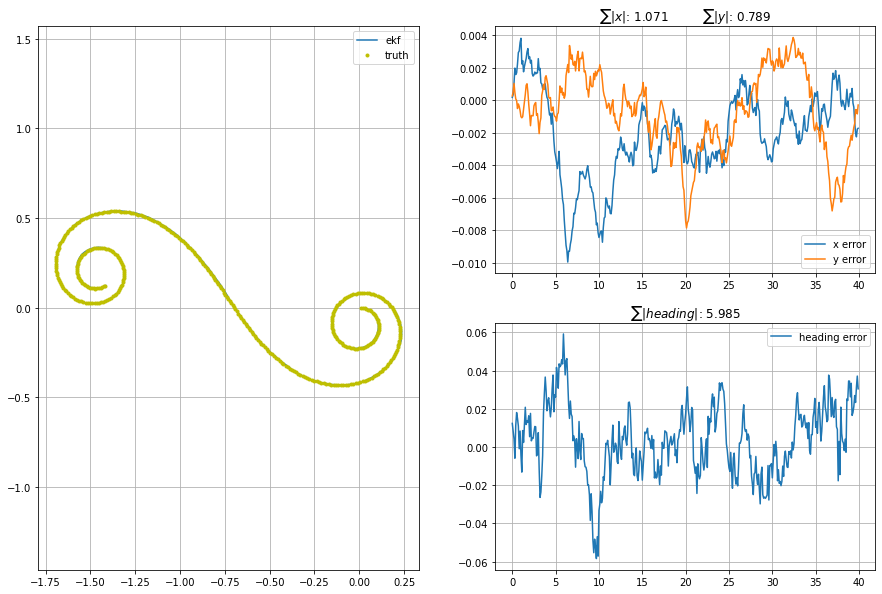

In [33]:
# plot a bunch of stuff
err = savex - save
ex = err[:,0]
ey = err[:,1]
eh = err[:,2]
    

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(save[:,0], save[:,1], label="ekf")
plt.plot(savex[:,0], savex[:,1], "y.", label="truth")
# plt.plot(savexn[:,0], savexn[:,1], label="noisey")
plt.axis('equal')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.title(f"$\sum |x|$: {np.sum(np.abs(ex)):.3f}         $\sum |y|$: {np.sum(np.abs(ey)):.3f}")
# plt.plot(times, np.cumsum(savex[:,0] - save[:,0], axis=0), label="x cum error")
# plt.plot(times, np.cumsum(savex[:,1] - save[:,1], axis=0), label="y cum error")
plt.plot(times, ex, label="x error")
plt.plot(times, ey, label="y error")
plt.legend();
plt.grid(True);
plt.subplot(224)
plt.title(f"$\sum |heading|$: {np.sum(np.abs(eh)):.3f}")
# plt.plot(times, np.cumsum(savex[:,2] - save[:,2], axis=0), label="heading cum error")
plt.plot(times, eh, label="heading error")
plt.legend()
plt.grid(True);

# print(f"trapz:  x: {np.trapz(ex):.3f} y: {np.trapz(ey):.3f} heading: {np.trapz(eh):.3f}")
# print(f"x: {np.sum(np.abs(ex)):.3f} y: {np.sum(np.abs(ey)):.3f} heading: {np.sum(np.abs(eh)):.3f}")

# UAV

In [34]:
from thundercougarfalconbird.uav import ParrotDrone

In [35]:
savex = []

drone = ParrotDrone()
senpos = SensorNoise(0.001,0.01)
senhead = SensorNoise(0.0,0.1)

x = np.zeros(13)
x[2] = 3
x[9] = 1
dt = 0.01
rk = RK4(drone.eqns, dt)
times = np.arange(0,40,dt)
saveu = []

for t in times:
    # made a simple changing control effort that makes
    # an interesting path
    s = 50.0
    u = [s,s,s,.9*s]
    saveu.append(u)
    x = rk(t,x,u)
    savex.append(x)
    
savex = np.array(savex)
num = len(savex)
sen = np.hstack((senpos.noise(num,9), senhead.noise(num,4)))
savexn = savex + sen
saveu = np.array(saveu)

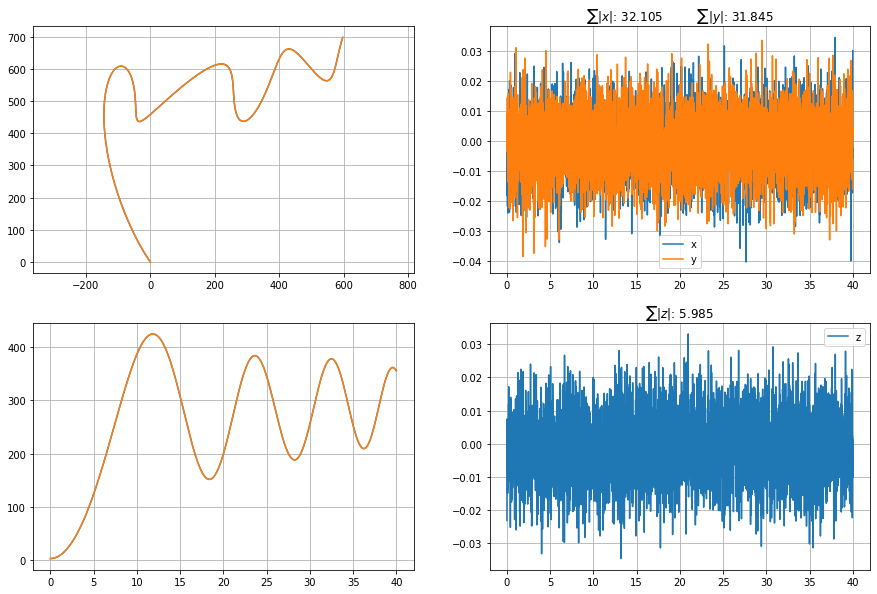

In [36]:
err = savex - savexn
ex = err[:,0]
ey = err[:,1]
ez = err[:,2]

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(savex[:,0], savex[:,1])
plt.plot(savexn[:,0], savexn[:,1])
plt.axis('equal')
plt.grid(True)

plt.subplot(223)
plt.plot(times, savex[:,2])
plt.plot(times, savexn[:,2])
plt.grid(True)

plt.subplot(222)
plt.title(f"$\sum |x|$: {np.sum(np.abs(ex)):.3f}         $\sum |y|$: {np.sum(np.abs(ey)):.3f}")
plt.plot(times,ex, label="x")
plt.plot(times,ey, label="y")
plt.legend()
plt.grid(True);

plt.subplot(224)
plt.title(f"$\sum |z|$: {np.sum(np.abs(eh)):.3f}")
plt.plot(times, ez, label="z")
plt.legend()
plt.grid(True);

In [37]:
# ekf = EKF(drone.eqns, dt)
# ekf.reset(3,3)
# # ekf.R *= [0.01,0.01,0.1] # measurement
# ekf.Q *= [.05,.05,.1] # process
# # ekf.Q *= [5,5,10] # process

# savep = []
# save = []

# for i in range(num):
#     u = saveu[i]
#     ekf.predict(u)
    
#     meas = savexn[i]
#     y = ekf.update(meas)
#     savep.append(np.trace(ekf.P))
    
#     save.append(y)
    
# save = np.array(save)
# savep = np.array(savep)